In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
import numpy.linalg as LA
from sklearn import datasets, svm, metrics
import cv2


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Connect GDrive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
!ls gdrive/MyDrive/CSC2515_Project/data/out

test  train  valid


In [5]:
# setting data paths
ROOT = "gdrive/MyDrive/CSC2515_Project/"
data = "gdrive/MyDrive/CSC2515_Project/data/out"

In [6]:
from sklearn.decomposition import KernelPCA 
from PIL import Image

In [7]:
#function to load images into dataframe
def loaddata(rootdir):
    import os
    imagelist = []
    for (dirpath,dirnames,filenames) in os.walk(rootdir,followlinks=True):
      for file in filenames:
        if '.jpeg' in file:
          datalabel = dirpath.split('/')[-2]
          if (dirpath.split('/')[-1]=='normal'):
            classlabel = 0
          elif (dirpath.split('/')[-1]=='pneumonia'):
            classlabel = 1
          else:
            classlabel = 2
          imagelist.append((dirpath+'/'+ file,datalabel,classlabel))
    return pd.DataFrame(imagelist,columns=['image','data','class'])

In [8]:
#flatten images to array with additional preprocessing
def flatImages(dataset,selectedLabels):
    vals =[]
    for i in range(len(dataset.values)):
        imgpath = dataset.iloc[i].image
        img = Image.open(imgpath).convert('L') #Luminance or brightness 
        img = img.resize((128,128), Image.ANTIALIAS) #reshape 
        img = np.array(img)
        vmax = img.max()
        vmin = img.min()
        threshold = vmin + 0.9 * (vmax - vmin)
        _, thres = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
        equalized = cv2.equalizeHist(img)
        vals.append(equalized)
    datasetlabels = dataset.loc[:,dataset.columns == 'class']
    trainData= np.array(vals)
    trainlabel= np.array(datasetlabels)
    idx = [k for k in range(len(trainlabel)) if trainlabel[k] in selectedLabels]
    N = len(idx)
    X = np.zeros((N, 128 * 128), dtype=np.uint8)
    T = np.zeros((N, 1), dtype=np.uint8)
    for i in range(N):
        T[i] = trainlabel[idx[i]]
    return trainData,T

In [9]:
train = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/train')
valid = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/valid')
test = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/test')

from sklearn.utils import shuffle

train = shuffle(train)
valid = shuffle(valid)
test = shuffle(valid)

print(train.shape)
print(valid.shape)
print(test.shape)

train['class'].unique()

(1892, 3)
(399, 3)
(399, 3)


array([1, 0, 2])

In [10]:
X_train,Y_train = flatImages(train, selectedLabels=[0,1,2])
X_test,Y_test = flatImages(test, selectedLabels=[0,1,2])
X_valid,Y_valid = flatImages(valid, selectedLabels=[0,1,2])

X_train = X_train.reshape(-1,X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(-1,X_test.shape[1]*X_test.shape[2])
X_valid = X_valid.reshape(-1,X_valid.shape[1]*X_valid.shape[2])

PCA and Kernel PCA


In [12]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

In [15]:
# PCA 
pca = PCA(n_components=1024, random_state=2515)

In [14]:
# Kernel PCA
pca = KernelPCA(n_components=1024, 
                            kernel="poly", 
                            gamma=0.5)

In [16]:
projected_X_train = pca.fit_transform(X_train)
projected_X_valid = pca.transform(X_valid)
projected_X_test = pca.transform(X_test)

In [ ]:
projected_X_test.shape

(399, 1024)

In [ ]:
approximate_X_train = pca.inverse_transform(projected_X_train)

In [ ]:
approximate_X_train = approximate_X_train.reshape(-1,128,128)

Sanity Check

*Original*

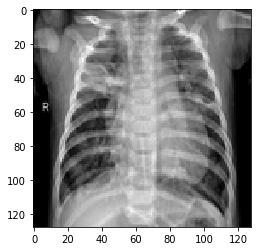

In [ ]:
plt.imshow((X_train[4]).reshape(128,128),interpolation = 'None', cmap = 'gray')

*Inverse Transformed*

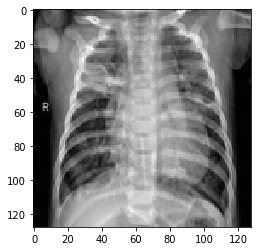

In [ ]:
plt.imshow((approximate_X_train[4]).reshape(128,128),interpolation = 'None', cmap = 'gray')

In [ ]:
X_train.shape

(1892, 16384)

In [ ]:
projected_X_train.shape

(1892, 1024)

(array([0, 1, 2], dtype=uint8), array([ 238, 1493,  161]))

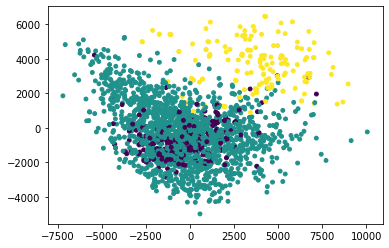

In [ ]:
plt.scatter(projected_X_train[:, 0], projected_X_train[:, 1], s = 15,
          c = Y_train)

np.unique(Y_train, return_counts=True)

Reconstruction error

In [ ]:
#projection loss
loss = np.sum((X_valid - approximate_X_valid.reshape(-1,approximate_X_valid.shape[1]*approximate_X_valid.shape[2])) ** 2, axis=1).mean()
loss

30531.405161095172

Experiementing with different # PCA components

In [ ]:
X_train.shape

(1892, 16384)

In [ ]:
n_components = range(1, 40, 2) 
Z = scale(X_train)
acc_svm = []
loss = []
for i in n_components:
  # PCA 
  pca = PCA(n_components=int(np.power(i, 2)), random_state=2515)
  projected_X_train = pca.fit_transform(X_train)  
  projected_X_valid = pca.transform(X_valid)
  # SVM
  model = SVC(kernel='rbf')
  model.fit(projected_X_train,  Y_train.reshape(-1, ))
  Y_valid_predicted = model.predict(projected_X_valid)
  acc_svm.append(metrics.accuracy_score(Y_valid_predicted, Y_valid))
  # Reconstruction loss
  approximate_X_valid = pca.inverse_transform(projected_X_valid)
  loss.append(np.sum((X_valid - approximate_X_valid) ** 2, axis=1).mean())
  

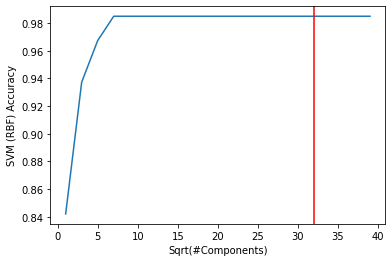

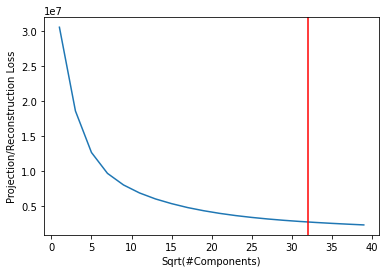

In [ ]:
# https://stackoverflow.com/questions/36566844/pca-projection-and-reconstruction-in-scikit-learn

plt.plot(range(1, 40, 2), acc_svm)
plt.xlabel('Sqrt(#Components)')
plt.ylabel('SVM (RBF) Accuracy')
plt.axvline(x=32, c='red')
plt.show()
plt.plot(range(1, 40, 2), loss)
plt.xlabel('Sqrt(#Components)')
plt.ylabel('Projection/Reconstruction Loss')
plt.axvline(x=32, c='red')
plt.show()

SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:

def svm_model(feature_vector_x, feature_vector_y):
  params = {'C':[0.01, 0.1, 1, 10, 100],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
       'kernel':['rbf', 'poly', 'linear', 'sigmoid']}
  classifier_linear = GridSearchCV(SVC(decision_function_shape='ovr'), params, cv=10)
  classifier_linear.fit(feature_vector_x, feature_vector_y)
  print('train score:', metrics.accuracy_score(classifier_linear.predict(feature_vector_x), feature_vector_y))
  print(classifier_linear.best_params_)
  return classifier_linear

*Test accuracy*

In [21]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [ ]:
def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        clf = svm_model(X_train, Y_train.reshape(-1,))
        Y_pred = clf.predict(X_test)
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

In [ ]:
average_performance(5, projected_X_train, Y_train, projected_X_test, Y_test)

train score: 1.0
{'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
train score: 1.0
{'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
train score: 1.0
{'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
train score: 1.0
{'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
train score: 1.0
{'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
Mean Accuracy:  0.9774436090225563 +- 0.0
Mean Precision:  0.965079365079365 +- 1.5412366411992055e-16
Mean Recall:  0.9659918107370336 +- 1.5412366411992055e-16
Mean F1:  0.9653383828857407 +- 1.5412366411992055e-16


XGBoost

In [ ]:
# XGBoost
from xgboost import XGBClassifier

def xgboost_model(feature_vector_x, feature_vector_y):
  xgb = XGBClassifier()
  param_grid = {
     'xgb__n_estimators': [50, 100, 150, 200],
     'max_depth': range(1, 11, 2)}
  grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5, 
                             n_jobs = 1, verbose = 0, return_train_score=True)

  grid_search.fit(feature_vector_x, feature_vector_y)
  print(grid_search.best_params_)

  print('train score:', metrics.accuracy_score(grid_search.predict(feature_vector_x), feature_vector_y))

  return grid_search

*Test accuracy*

In [ ]:
def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        clf = xgboost_model(X_train, Y_train.reshape(-1,))
        Y_pred = clf.predict(X_test)
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

average_performance(5, projected_X_train, Y_train, projected_X_test, Y_test)

DT

In [ ]:
# DT
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
def dt_model(feature_vector_x, feature_vector_y):
  tree_param = {'criterion':['gini','entropy'],
                'max_depth':range(1, 50, 5)}
  clf = GridSearchCV(DecisionTreeClassifier(), tree_param, cv=10)
  clf.fit(feature_vector_x, feature_vector_y)
  print(clf.best_params_)
  print('train score:', metrics.accuracy_score(clf.predict(feature_vector_x), feature_vector_y))
  return dtclassifier


*Test accuracy*

In [ ]:
def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        clf = dt_model(X_train, Y_train.reshape(-1,))
        Y_pred = clf.predict(X_test)
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

average_performance(5, projected_X_train, Y_train, projected_X_test, Y_test)

train score: 1.0
train score: 1.0
train score: 1.0
train score: 1.0
train score: 1.0
Mean Accuracy:  0.8857142857142858 +- 0.004175105421350094
Mean Precision:  0.8156194067194958 +- 0.007741745955366924
Mean Recall:  0.8029784129773148 +- 0.006371182747347196
Mean F1:  0.8027693130408396 +- 0.008665988368629567


Basic 2D CNN

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

batch_size = 256
num_classes = 3
epochs = 10

CONV1 = 64
CONV2 = 128
DENSE = 128
KERNEL_CONV=3
KERNEL_POOL=2
ACTIVATION='relu'
DROPOUT = 0.1
OPTIMIZER='adam'

#input image dimensions
img_rows, img_cols = 32, 32

model = Sequential()
model.add(Conv2D(CONV1, kernel_size=(KERNEL_CONV, KERNEL_CONV),
                 activation=ACTIVATION,
                 input_shape=(img_rows,img_cols,1)))
model.add(MaxPooling2D((KERNEL_POOL, KERNEL_POOL)))
model.add(Conv2D(CONV2, (KERNEL_CONV, KERNEL_CONV), activation='relu'))
model.add(Flatten())
model.add(Dense(DENSE, activation=ACTIVATION, name ='my_dense'))
model.add(Dropout(DROPOUT))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer = OPTIMIZER, metrics = ['accuracy'])


In [ ]:
def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        history = model.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train, num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.20)
        Y_pred = np.argmax(model.predict(X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)), axis=1)        
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

average_performance(20, projected_X_train, Y_train, projected_X_test, Y_test)

Epoch 1/10
6/6 [==============================] - 0s 45ms/step - loss: 3.5484e-05 - accuracy: 1.0000 - val_loss: 0.6161 - val_accuracy: 0.9182
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 1.9234e-05 - accuracy: 1.0000 - val_loss: 0.6101 - val_accuracy: 0.9208
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 3.5312e-05 - accuracy: 1.0000 - val_loss: 0.6070 - val_accuracy: 0.9208
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 2.1384e-05 - accuracy: 1.0000 - val_loss: 0.6084 - val_accuracy: 0.9208
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 2.3875e-05 - accuracy: 1.0000 - val_loss: 0.6071 - val_accuracy: 0.9235
Epoch 6/10
6/6 [==============================] - 0s 36ms/step - loss: 1.0023e-04 - accuracy: 1.0000 - val_loss: 0.5907 - val_accuracy: 0.9235
Epoch 7/10
6/6 [==============================] - 0s 36ms/step - loss: 5.6501e-05 - accuracy: 1.0000 - val_loss: 0.5859 - val_accuracy: 0.9208

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim([0, 1])
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim([0, 2.5])
plt.show()

*Intermediate Layer*

In [ ]:
from keras.models import Model
layer_name='my_dense'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18_input (InputLayer  [(None, 32, 32, 1)]      0         
 )                                                               
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 flatten_9 (Flatten)         (None, 21632)             0         
                                                                 
 my_dense (Dense)            (None, 128)               276902

In [ ]:
intermediate_output_X_train = intermediate_layer_model.predict(projected_X_train.reshape(projected_X_train.shape[0],img_rows,img_cols,1)) 
intermediate_output_X_train = pd.DataFrame(data=intermediate_output_X_train)

intermediate_output_X_valid = intermediate_layer_model.predict(projected_X_valid.reshape(projected_X_valid.shape[0],img_rows,img_cols,1)) 
intermediate_output_X_valid = pd.DataFrame(data=intermediate_output_X_valid)

intermediate_output_X_test = intermediate_layer_model.predict(projected_X_test.reshape(projected_X_test.shape[0],img_rows,img_cols,1)) 
intermediate_output_X_test = pd.DataFrame(data=intermediate_output_X_test)

*XGBOOST*

*Test accuracy*

In [ ]:
def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        clf = xgboost_model(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

average_performance(5, intermediate_output_X_train, Y_train.ravel(), intermediate_output_X_test, Y_test.ravel())

{'xgb__n_estimators': 1}
train score: 0.992600422832981
{'xgb__n_estimators': 1}
train score: 0.992600422832981
{'xgb__n_estimators': 1}
train score: 0.992600422832981
{'xgb__n_estimators': 1}
train score: 0.992600422832981
{'xgb__n_estimators': 1}
train score: 0.992600422832981
Mean Accuracy:  0.8972431077694235 +- 0.0
Mean Precision:  0.8451070916327715 +- 0.0
Mean Recall:  0.8042094171294698 +- 0.0
Mean F1:  0.8120557611930457 +- 1.5412366411992055e-16


*SVM*

*Test accuracy*

In [ ]:
def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        clf = svm_model(X_train, Y_train.ravel())
        Y_pred = clf.predict(X_test)
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

average_performance(5, intermediate_output_X_train, Y_train.ravel(), intermediate_output_X_test, Y_test.ravel())

train score: 0.9746300211416491
{'C': 1, 'kernel': 'rbf'}
train score: 0.9746300211416491
{'C': 1, 'kernel': 'rbf'}
train score: 0.9746300211416491
{'C': 1, 'kernel': 'rbf'}
train score: 0.9746300211416491
{'C': 1, 'kernel': 'rbf'}
train score: 0.9746300211416491
{'C': 1, 'kernel': 'rbf'}
Mean Accuracy:  0.8997493734335841 +- 1.5412366411992055e-16
Mean Precision:  0.8715785455239548 +- 1.5412366411992055e-16
Mean Recall:  0.7850566868522063 +- 0.0
Mean F1:  0.8105615574591131 +- 0.0
